<a href="https://colab.research.google.com/github/suchig/Hotel-Reviews/blob/master/Hotel_Review_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Download the data
!wget -O hotels.zip https://www.dropbox.com/s/owu0wbo58rcrq41/515k-hotel-reviews-data-in-europe.zip?dl=1
!unzip hotels.zip

--2019-07-21 01:12:04--  https://www.dropbox.com/s/owu0wbo58rcrq41/515k-hotel-reviews-data-in-europe.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/owu0wbo58rcrq41/515k-hotel-reviews-data-in-europe.zip [following]
--2019-07-21 01:12:04--  https://www.dropbox.com/s/dl/owu0wbo58rcrq41/515k-hotel-reviews-data-in-europe.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3229c89f8256ff47bee96056fe.dl.dropboxusercontent.com/cd/0/get/AlERrScaNTDXcik65gr_90KJT0ure2aEGiCH4MVHJiwY1aqGDncB1SUGZnzZGNAfbsTzuGamseHchv-DXfNN6-Qz5x9yY0lQoUJANT01I038BQ/file?dl=1# [following]
--2019-07-21 01:12:04--  https://uc3229c89f8256ff47bee96056fe.dl.dropboxusercontent.com/cd/0/get/AlERrScaNTDXcik65gr_90KJT0ure2aEGiCH4MVHJiwY1aqGDncB1SUGZn

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from scipy.sparse import hstack, csr_matrix

#!pip install   xgboost
import xgboost as xgb
from xgboost import XGBRegressor

import nltk
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

---
# Initialization of data
Hotel reviews csv file is read. Its structure and information is analyzed


In [0]:
hotels = pd.read_csv("Hotel_Reviews.csv")
print(hotels.shape)
print(hotels.info())

(515738, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
Hotel_Address                                 515738 non-null object
Additional_Number_of_Scoring                  515738 non-null int64
Review_Date                                   515738 non-null object
Average_Score                                 515738 non-null float64
Hotel_Name                                    515738 non-null object
Reviewer_Nationality                          515738 non-null object
Negative_Review                               515738 non-null object
Review_Total_Negative_Word_Counts             515738 non-null int64
Total_Number_of_Reviews                       515738 non-null int64
Positive_Review                               515738 non-null object
Review_Total_Positive_Word_Counts             515738 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515738 non-null int64
Reviewer_Score                                515738

Note above that several features are String/Object. These have to be converted to numeric datatypes for prediction. 
1. Country from address is stripped and categorized as numeric. (Address will be removed during prediction)
2. Review_Date is converted to numeric
3. Reviewer_Nationality is categorized to numeric
4. Days_since_review is converted to numeric

In [0]:
split_address = hotels['Hotel_Address'].str.split()
items = [item[-1] for item in split_address]

hotels["Country"], country_unique = pd.factorize(items)

hotels["Review_Date"] = hotels["Review_Date"].str.replace('/','')
hotels["Review_Date"] = hotels["Review_Date"].astype(int)

hotels["Reviewer_Nationality"], reviewer_nationality_unique = hotels['Reviewer_Nationality'].factorize()

split_days = hotels['days_since_review'].str.split()
items = [int(item[0]) for item in split_days]
hotels['days_since_review']=items

Tag values have to be analyzed as they may have some significance in how the reviewer has rated. 

In [0]:
#Split tags
tag_values=hotels['Tags'].map(lambda val: re.sub('[\[\]\']','',val)) 
tag_values = tag_values.str.split(",",expand=True)

Analyzing the tags, it is visible that there are a lot of tags around different types of rooms that do not seem to provide a categorical value. Hence focusing on tags that do not pertain to room, it is possible to create four features.

1. Trip Type - Leisure or Business
2. Group Type - Solo, Group, Family etc
3. Mobile or not
4. Number of nights stayed

In [0]:
hotels["Trip"] = 0

hotels.loc[hotels['Tags'].str.find('Leisure')!=-1,["Trip"]]=1
hotels.loc[hotels['Tags'].str.find('Business')!=-1,["Trip"]]=2

hotels['Group_Type'] = 0
hotels.loc[hotels['Tags'].str.find('Couple')!=-1,["Group_Type"]]=1
hotels.loc[hotels['Tags'].str.find('Family with older children')!=-1,["Group_Type"]]=2
hotels.loc[hotels['Tags'].str.find('Family with young children')!=-1,["Group_Type"]]=3
hotels.loc[hotels['Tags'].str.find('Group')!=-1,["Group_Type"]]=4
hotels.loc[hotels['Tags'].str.find('Solo traveler')!=-1,["Group_Type"]]=5
hotels.loc[hotels['Tags'].str.find('Travelers with friends')!=-1,["Group_Type"]]=6
hotels.loc[hotels['Tags'].str.find('With a pet')!=-1,["Group_Type"]]=7

hotels['Mobile'] = 0
hotels.loc[hotels['Tags'].str.find('Submitted from a mobile device')!=-1,["Mobile"]]=1

hotels["Stayed"]=0
for i in range(1,21):
  hotels.loc[hotels['Tags'].str.find('Stayed '+str(i)+' night')!=-1,["Stayed"]]=i

"No Negative" and "No Positive" signify no comments from Reviewers. If this is left as is, "No" and "Positive" will be counted as separate tokens. These could be blanked out. But that would not provide valuable insights. So these are converted into NoNegative and NoPositive.

Also, null values as filled with zeroes in latitude and longitude.

In [0]:
hotels[hotels['Negative_Review']=='No Negative']['Negative_Review']='NoNegative'
hotels[hotels['Positive_Review']=='No Positive']['Positive_Review']='NoPositive'

hotels[hotels["lat"].isnull()]["lat"]=0
hotels[hotels["lng"].isnull()]["lng"]=0

---
# Regression of Hotel data
This section will provide a prediction model for Reviewer score of Hotel data. It seems logical that when a reviewer scores after providing comments, the score will be associated with the reviews in some statistical pattern.

Hence, the approach will be to use the weight of tokens that yield positive and negative reviews to train the model to predict Reviewer score.

To calculate the weight of words in Positive and Negative reviews, TFID values are derived for each token in both Positive as well as Negative reviews.

In [0]:
lemmatizer = WordNetLemmatizer()
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

#method to split sentences to lemmatized words
def tokenize(text):
  
  # Remove punctuations
  text = text.lower().translate(remove_punct_dict)

  # Remove numeric entries
  text = re.sub("\d+", " ", text)
  
  #tokenize the sentence to words
  tokens = nltk.word_tokenize(text)
  
  #lemmatize the tokens
  tokens = [lemmatizer.lemmatize(token) for token in tokens]
  
  #remove below custom words since they are typing issues
  #remove any single letter tokens
  custom_stopWords=['wa'] 
  tokens = [t for t in tokens if ((t not in custom_stopWords) and (len(t)>1))]
  
  return tokens

In [0]:
nltk.download('punkt')
nltk.download('wordnet')
count_vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
tfid_transformer = TfidfTransformer()

count_total = count_vectorizer.fit_transform(hotels['Positive_Review']+" "+hotels['Negative_Review'])
tfid_total = tfid_transformer.fit_transform(count_total)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


A histogram of Review Score shows that it possesses a Gamma Distribution. Hence a Gamma based regression might provide good prediction model

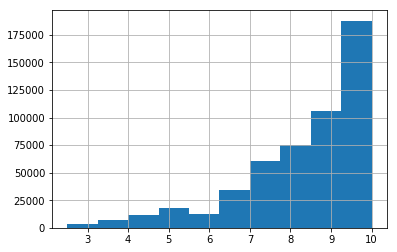

In [0]:
hotels['Reviewer_Score'].hist()

Function fit_and_infer will train a model using XGBoost (Gamma regression was not better than Linear regression). It will also predict output for test values and plot a residual graph.



In [0]:
def fit_and_infer(X_train,y_train,X_test,y_test,num_round=200):
  xgb_train = xgb.DMatrix(X_train,label=y_train)
  xgb_x_test = xgb.DMatrix(X_test)
  
  xgb_params = {
        'verbosity' : 0,
        #'objective': 'reg:gamma',
        'nthread': 5,
        #'max_depth':6,
        'eta':0.5
  }
  
  watchlist = [(xgb_train, 'train')]
  
  clf = xgb.train(xgb_params, xgb_train, num_round, watchlist,verbose_eval=50)
  y_pred = clf.predict(xgb_x_test)
  print("r2 :",r2_score(y_test,y_pred))
  print("mse :",mean_squared_error(y_test,y_pred))
  
  plt.figure(figsize=(10,6))
  plt.scatter(y_test,y_pred);
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r',lw=4);
  return y_pred

TFID values ate split as X train andX  test. Reviewer Score is split as Y train and Y test. fit_and_infer provides the residual chart, r2 and mse

[0]	train-rmse:4.21785
[50]	train-rmse:1.17271
[100]	train-rmse:1.1319
[150]	train-rmse:1.10672
[199]	train-rmse:1.08787
r2 : 0.4864033720707197
mse : 1.3795434623043448


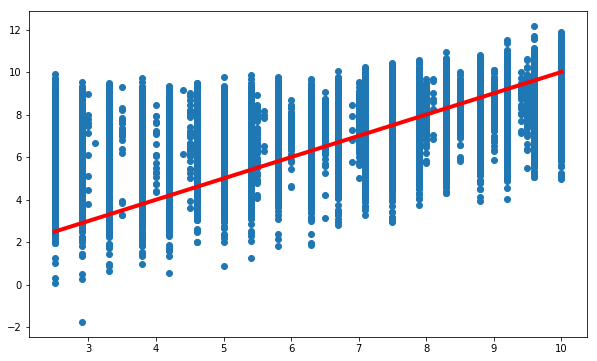

In [0]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    tfid_total, hotels['Reviewer_Score'],random_state=27)

sc = StandardScaler(with_mean=False)
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

y_pred = fit_and_infer(sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

From the chart and from statistics ( r2 of 0.48, mse of 1.38), it is not clear if this has been a successful model. If the model can predict +/- 1 rating when compared to the actual, it should be a reasonable model. 

This requires a Error histogram.

In [0]:
errors = np.abs(sparse_Y_test-y_pred)

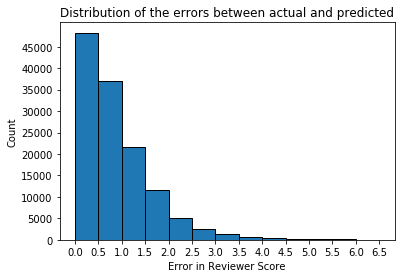

In [0]:
plt.hist(errors, bins=np.arange(0,7,0.5),edgecolor='black')
plt.title('Distribution of the errors between actual and predicted')
plt.xlabel('Error in Reviewer Score')
plt.ylabel('Count')
plt.xticks(np.arange(0,7,0.5));
plt.yticks(np.arange(0,50000,5000));

In [0]:
print("Error rate: ", sum(errors>1)/len(errors))

Error rate:  0.33941133129096057


Above shows that 33% of test data had predictions more than +/- 1 rating.


**Hotel features with TFID values**

There are other features in the hotel data that could be used along with TFID values for prediction.

In order to do the same, hotel data has to be cleaned. 

- Some of the string values are already converted to numeric
- Positive_review and Negative_Review can be removed since TFID values will be introduced
- Hotel Address can be dropped since Country attribute is retained
- Tags are removed now since the same has been split into 4 other numeric features

A correlation matrix will show which values are important for Review_Score

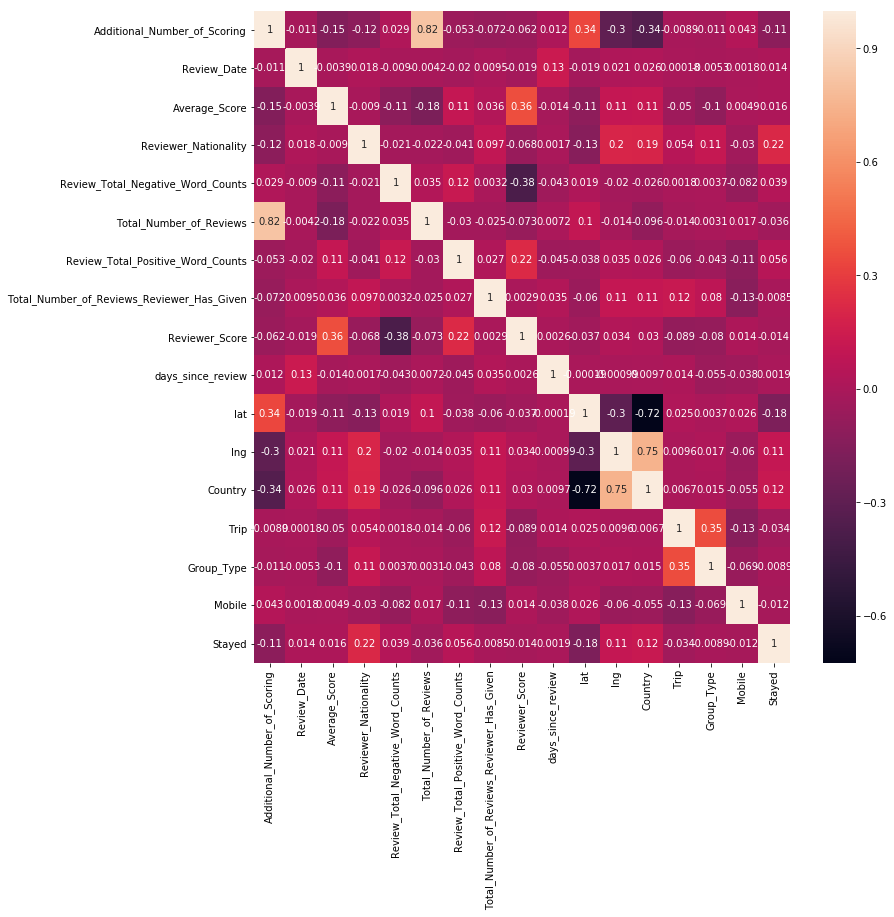

In [0]:
plt.figure(figsize=(12, 12))
sns.heatmap(hotels.corr(),annot=True);

Columns like Total Number of Reviews, Review Date are removed based on heatmap above. (Total Negative words , lat and lng are not removed becasue they gave better mse values during trials)

In [0]:
hotels_edited = hotels.drop(
    ['Hotel_Address','Reviewer_Score','Hotel_Name','Negative_Review',
     'Positive_Review','Tags','Total_Number_of_Reviews','Review_Date',
     'Trip','Group_Type','Stayed'],axis=1)

Edited hotel details are stacked with TFID values and prediction is done

[0]	train-rmse:4.17961
[50]	train-rmse:1.08395
[100]	train-rmse:1.0494
[150]	train-rmse:1.02821
[199]	train-rmse:1.01125
r2 : 0.5471981244899145
mse : 1.2162460442888592


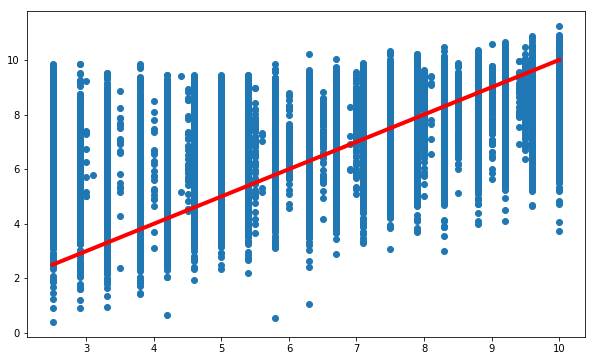

In [0]:
hotels_edited_tfid = hstack([csr_matrix(hotels_edited),tfid_total])

sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    hotels_edited_tfid, hotels['Reviewer_Score'],random_state=27)

sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

y_pred = fit_and_infer(
    sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

r2 and mse values of this model are better than previous one. Again the residual chart does not give much idea. hence error histogram is drawn.

Error rate:  0.2995152596269438


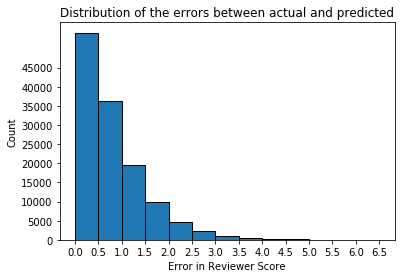

In [0]:
errors = np.abs(sparse_Y_test-y_pred)
plt.hist(errors, bins=np.arange(0,7,0.5),edgecolor='black')
plt.title('Distribution of the errors between actual and predicted')
plt.xlabel('Error in Reviewer Score')
plt.ylabel('Count')
plt.xticks(np.arange(0,7,0.5));
plt.yticks(np.arange(0,50000,5000));
print("Error rate: ", sum(errors>1)/len(errors))

And error rate of 30% is better than 33% from previous run. Still it will be interesting to see how this will look with information from hotel and no input from tfid

**Only hotel data**

[0]	train-rmse:4.18043
[50]	train-rmse:1.19769
[100]	train-rmse:1.17822
[150]	train-rmse:1.16188
[199]	train-rmse:1.14765
r2 : 0.431030843948188
mse : 1.5282765438876225


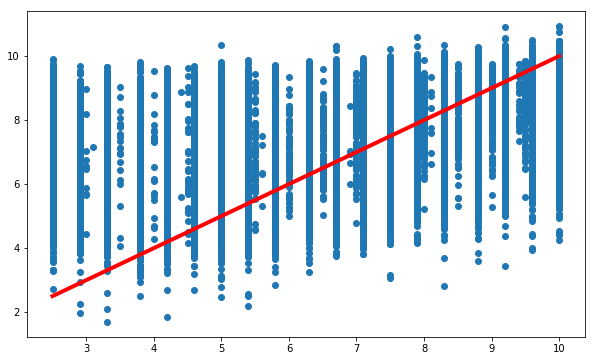

In [0]:
sparse_X_train, sparse_X_test, sparse_Y_train, sparse_Y_test = train_test_split(
    hotels_edited, hotels['Reviewer_Score'],random_state=27)

sc = StandardScaler()
sparse_X_train = sc.fit_transform(sparse_X_train)
sparse_X_test = sc.transform(sparse_X_test)

y_pred = fit_and_infer(
    sparse_X_train,sparse_Y_train,sparse_X_test,sparse_Y_test )

Error rate:  0.34208709815023075


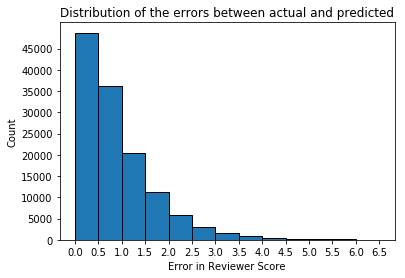

In [0]:
errors = np.abs(sparse_Y_test-y_pred)
plt.hist(errors, bins=np.arange(0,7,0.5),edgecolor='black')
plt.title('Distribution of the errors between actual and predicted')
plt.xlabel('Error in Reviewer Score')
plt.ylabel('Count')
plt.xticks(np.arange(0,7,0.5));
plt.yticks(np.arange(0,50000,5000));
print("Error rate: ", sum(errors>1)/len(errors))

The r2 value of  and mse value of of this model shows that TFID values with Hotel Features give a better model for prediction.